In [1]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Optional, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_community.document_loaders import Docx2txtLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
import docx2txt
import inspect
import sys

In [2]:
# Load environment variables (for LLM API keys)
load_dotenv()

True

In [3]:
# Define State with explicit human interaction points
class AgentState(TypedDict):
    conversation: Annotated[List[dict], lambda a, b: a + b]
    medical_report: Optional[str]
    pending_action: Optional[str]
    pending_questions: Annotated[List[str], lambda a, b: a + b]
    task_status: Annotated[dict, lambda a, b: {**a, **b}]

# Initialize state
initial_state = AgentState({
    "conversation": [],
    "medical_report": None,
    "pending_action": None,
    "pending_questions": [],
    "task_status": {
        "symptoms_collected": False,
        "report_processed": False,
        "verification_complete": False,
        "follow_up_scheduled": False
    }
})


In [4]:
# Define Tools (as LangGraph nodes)
class MedicalTools:
    def __init__(self):
        self.llm = ChatOpenAI(model="gpt-4-1106-preview", temperature=0.3)
    
    def symptom_interview(self, state: AgentState) -> dict:
        """Conduct symptom interview with human interaction"""
        if not state["pending_questions"]:
            prompt = ChatPromptTemplate.from_template("""
            Generate the next diagnostic question based on:
            Previous conversation: {history}
            Current symptom status: {status}
            """)
            chain = prompt | self.llm
            question = chain.invoke({
                "history": state["conversation"],
                "status": state["task_status"]
            }).content
            return {
                "pending_action": "await_patient_response",
                "pending_questions": [question],
                "conversation": [{"role": "system", "content": "Generated question"}, 
                               {"role": "assistant", "content": question}]
            }
        else:
            # Get human input
            question = state["pending_questions"].pop(0)
            print(f"\n[SYMPTOM INTERVIEW] Question: {question}")
            response = input("Patient response: ")
            
            return {
                "conversation": [
                    {"role": "assistant", "content": question},
                    {"role": "user", "content": response}
                ],
                "task_status": {"symptoms_collected": len(state["conversation"]) > 5}
            }

    def process_report(self, state: AgentState) -> dict:
        """Handle document processing with human upload"""
        if not state["medical_report"]:
            print("\n[REPORT PROCESSING] Please upload your medical report (DOCX file):")
            file_path = input("File path: ")
            
            try:
                loader = Docx2txtLoader(file_path)
                docs = loader.load()
                report_text = "\n".join([doc.page_content for doc in docs])
            except Exception as e:
                print(f"Error loading document: {e}")
                report_text = docx2txt.process(file_path)
            
            return {
                "medical_report": report_text,
                "task_status": {"report_processed": True},
                "pending_action": "verify_report"
            }
        return state

    def handle_verification(self, state: AgentState) -> dict:
        """Verify report consistency with human confirmation"""
        prompt = ChatPromptTemplate.from_template("""
        Generate verification questions comparing:
        Symptoms: {symptoms}
        Report: {report}
        
        Create 2-3 questions to confirm consistency. Format as bullet points.
        """)
        
        chain = prompt | self.llm
        questions = chain.invoke({
            "symptoms": state["conversation"],
            "report": state["medical_report"]
        }).content.split("\n")
        
        print("\n[VERIFICATION] Please confirm these details:")
        answers = []
        for q in questions:
            if q.strip():
                ans = input(f"{q.strip()} (Y/N/Explain): ")
                answers.append({"question": q, "answer": ans})
        
        return {
            "conversation": [{"role": "system", "content": "Verification results"},
                           {"role": "user", "content": str(answers)}],
            "task_status": {"verification_complete": True}
        }

    def follow_up(self, state: AgentState) -> dict:
        """Handle follow-up coordination with human input"""
        print("\n[FOLLOW-UP] Please choose next steps:")
        print("1. Schedule doctor appointment")
        print("2. Request additional tests")
        print("3. Provide lifestyle recommendations")
        choice = input("Enter option number: ")
        
        prompt = ChatPromptTemplate.from_template("""
        Generate follow-up plan based on:
        Choice: {choice}
        Conversation: {history}
        Report: {report}
        """)
        
        chain = prompt | self.llm
        plan = chain.invoke({
            "choice": choice,
            "history": state["conversation"],
            "report": state["medical_report"]
        }).content
        
        return {
            "conversation": [{"role": "assistant", "content": plan}],
            "task_status": {"follow_up_scheduled": True}
        }

In [5]:
# Create Supervisor Agent
class SupervisorAgent:
    def __init__(self):
        self.llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)
        self.tools = MedicalTools()
    
    def decide_next_action(self, state: AgentState) -> str:
        """Router with human-in-the-loop awareness"""
        if state["pending_action"] == "await_patient_response":
            return "symptom_interview"
        
        if not state["task_status"]["symptoms_collected"]:
            return "symptom_interview"
        
        if not state["task_status"]["report_processed"]:
            return "process_report"
        
        if not state["task_status"]["verification_complete"]:
            return "handle_verification"
        
        if not state["task_status"]["follow_up_scheduled"]:
            return "follow_up"
        
        return "__end__"


In [6]:
# Build Workflow with Explicit Human Interaction
tools = MedicalTools()
supervisor = SupervisorAgent()
workflow = StateGraph(AgentState)

# Add nodes for each tool
workflow.add_node("symptom_interview", tools.symptom_interview)
workflow.add_node("process_report", tools.process_report)
workflow.add_node("handle_verification", tools.handle_verification)
workflow.add_node("follow_up", tools.follow_up)

# Add conditional edges
def router(state: AgentState):
    next_action = supervisor.decide_next_action(state)
    if next_action == "__end__":
        return END
    return next_action

workflow.add_conditional_edges(
    "symptom_interview",
    router
)
workflow.add_conditional_edges(
    "process_report",
    router
)
workflow.add_conditional_edges(
    "handle_verification",
    router
)
workflow.add_conditional_edges(
    "follow_up",
    router
)

# Set entry point
workflow.set_entry_point("symptom_interview")

# Compile the workflow
app = workflow.compile()


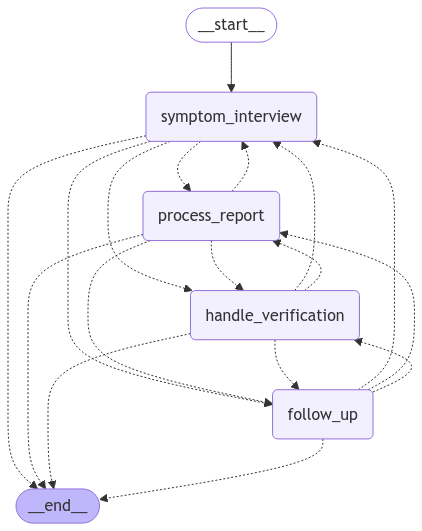

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [ ]:
# Run the system with human interaction
def run_medical_assistant():
    state = initial_state
    while True:
        result = app.invoke(state)
        state = result
        
        if result.get("pending_action"):
            print("\n[SYSTEM] Waiting for human input...")
            # Handle custom input processing here
        
        if result.get("__end__"):
            print("\n[SYSTEM] Consultation complete. Generating summary...")
            summary = tools.generate_summary(state)
            print(f"\nFINAL SUMMARY:\n{summary['conversation'][-1]['content']}")
            break

if __name__ == "__main__":
    run_medical_assistant()


[SYMPTOM INTERVIEW] Question: Based on the current symptom status indicating that no symptoms have been collected yet, the next diagnostic question to generate would be:

"Can you please describe the symptoms you are experiencing, including when they started and how they have progressed?"

[SYMPTOM INTERVIEW] Question: "Thank you for sharing that you are experiencing sneezing. To help narrow down the possible causes, could you tell me if you have any other symptoms, such as a runny or stuffy nose, itchy eyes, cough, or fever? Additionally, how long have you been sneezing, and have you noticed anything that seems to trigger it?"

[SYMPTOM INTERVIEW] Question: "Thank you for letting me know about your runny nose in addition to sneezing. Can you tell me how long these symptoms have been present? Also, have you experienced any other symptoms such as sore throat, headache, body aches, or fatigue? Have you been in contact with any known allergens or been exposed to others who are sick?"

[S